In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 40)


In [3]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc,
                             fbeta_score, accuracy_score, recall_score) # evaluation metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import gc
import mlflow
from mlflow.models import infer_signature
from lightgbm import LGBMClassifier


<h1>Analyse Exploratoire</h1>

<h3>Lecture des données</h3>

In [4]:
application_train = pd.read_csv('input/application_train.csv')
application_test = pd.read_csv('input/application_test.csv')

In [34]:
def get_df_info(datasets : list, df_names : list):
    info_df = pd.DataFrame({},)
    info_df['dataset'] = df_names
    info_df['nb_columns'] = [len(df.columns) for df in datasets]
    info_df['columns_name'] = [', '.join(list(df.columns)) for df in datasets]
    info_df['nb_rows'] = [len(df) for df in datasets]

    columns_type = pd.DataFrame({},)
    columns_type['dataset'] = df_names
    columns_type['numeric_columns'] = [len((df.select_dtypes(include=np.number)).columns) for df in datasets]
    columns_type['numeric_columns_name'] = [', '.join(list((df.select_dtypes(include=np.number)).columns)) for df in datasets]
    columns_type['object_columns'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
    columns_type['object_columns_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
    
    return info_df.style.background_gradient(cmap='PuBu'), columns_type.style.background_gradient(cmap='PuBu')

### Description des données

In [57]:
datasets = [application_train, application_test]
df_names = ["application_train", "application_test"]
get_df_info(datasets, df_names)
info_df,columns_type = get_df_info(datasets, df_names)
info_df


,dataset,nb_columns,columns_name,nb_rows
0,application_train,122,"SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR",307511
1,application_test,121,"SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FON

### Répartition variables numériques et qualitatives

In [58]:
columns_type

,dataset,numeric_columns,numeric_columns_name,object_columns,object_columns_name
0,application_train,106,"SK_ID_CURR, TARGET, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR",16,"NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, OCCUPATION_TYPE, WEEKDAY_APPR_PROCESS_START, ORGANIZATION_TYPE, FONDKAPREMONT_MODE, HOUSETYPE_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE"
1,application_test,105,"SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUME

In [39]:
# Function to calculate missing values by column# Funct 
def missing_values(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    cols_with_missing_values = [col for col in df.columns if df[col].isnull().mean() > 0]
    print('Number of columns with missing values: \n', len(cols_with_missing_values))
    print('-' * 80)

    return mis_val_table_ren_columns

In [40]:
missing_values(application_train)

Number of columns with missing values: 
 67
--------------------------------------------------------------------------------


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


## Variable Cible

(307511, 122)


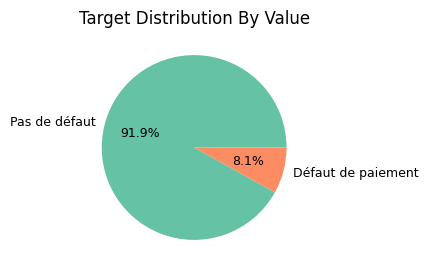

In [59]:
# Répartition de la variable cible
print(application_train.shape)

plt.figure(figsize=(3,3))
labels=["Pas de défaut","Défaut de paiement"]
plt.pie(application_train["TARGET"].value_counts(),
        labels = labels,
        autopct='%.01f%%',
        textprops={'fontsize':9},
        colors=sns.color_palette('Set2')
)
plt.title(label="Target Distribution By Value")
plt.show()

# Variables Numériques

In [24]:
numeric_features = application_train.select_dtypes(include=[np.number]).columns
application_train[numeric_features].describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,"307,511.000","307,511.000","307,511.000","307,511.000","307,511.000","307,499.000","307,233.000","307,511.000","307,511.000","307,511.000",...,"307,511.000","307,511.000","307,511.000","307,511.000","265,992.000","265,992.000","265,992.000","265,992.000","265,992.000","265,992.000"
mean,"278,180.519",0.081,0.417,"168,797.919","599,026.000","27,108.574","538,396.207",0.021,"-16,036.995","63,815.046",...,0.008,0.001,0.001,0.000,0.006,0.007,0.034,0.267,0.265,1.900
std,"102,790.175",0.272,0.722,"237,123.146","402,490.777","14,493.737","369,446.461",0.014,"4,363.989","141,275.767",...,0.090,0.024,0.023,0.018,0.084,0.111,0.205,0.916,0.794,1.869
min,"100,002.000",0.000,0.000,"25,650.000","45,000.000","1,615.500","40,500.000",0.000,"-25,229.000","-17,912.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,"189,145.500",0.000,0.000,"112,500.000","270,000.000","16,524.000","238,500.000",0.010,"-19,682.000","-2,760.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,"278,202.000",0.000,0.000,"147,150.000","513,531.000","24,903.000","450,000.000",0.019,"-15,750.000","-1,213.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,"367,142.500",0.000,1.000,"202,500.000","808,650.000","34,596.000","679,500.000",0.029,"-12,413.000",-289.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
max,"456,255.000",1.000,19.000,"117,000,000.000","4,050,000.000","258,025.500","4,050,000.000",0.073,"-7,489.000","365,243.000",...,1.000,1.000,1.000,1.000,4.000,9.000,8.000,27.000,261.000,25.000


- Certaines variables numériques sont en réalité des variables catégorielles
- CNT_CHILDREN, FLAG_DOCUMENT

In [63]:
def plot_distribution(df, FEATURES):
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(4, 2, figsize=(16, 20))

    for feature in FEATURES:
        if feature != 'TARGET':
            i += 1
            plt.subplot(4, 2, i)
            sns.kdeplot(t1[feature], bw=0.5, color='red', label="TARGET = 1")
            sns.kdeplot(t0[feature], bw=0.5, label="default = 0")
            plt.ylabel('Density plot', fontsize=12)
            plt.xlabel(feature, fontsize=12)
            plt.xticks(fontsize=12, rotation=90)  # Set the font size for x-axis labels
            plt.yticks(fontsize=12)  # Set the font size for y-axis labels

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

<Figure size 640x480 with 0 Axes>

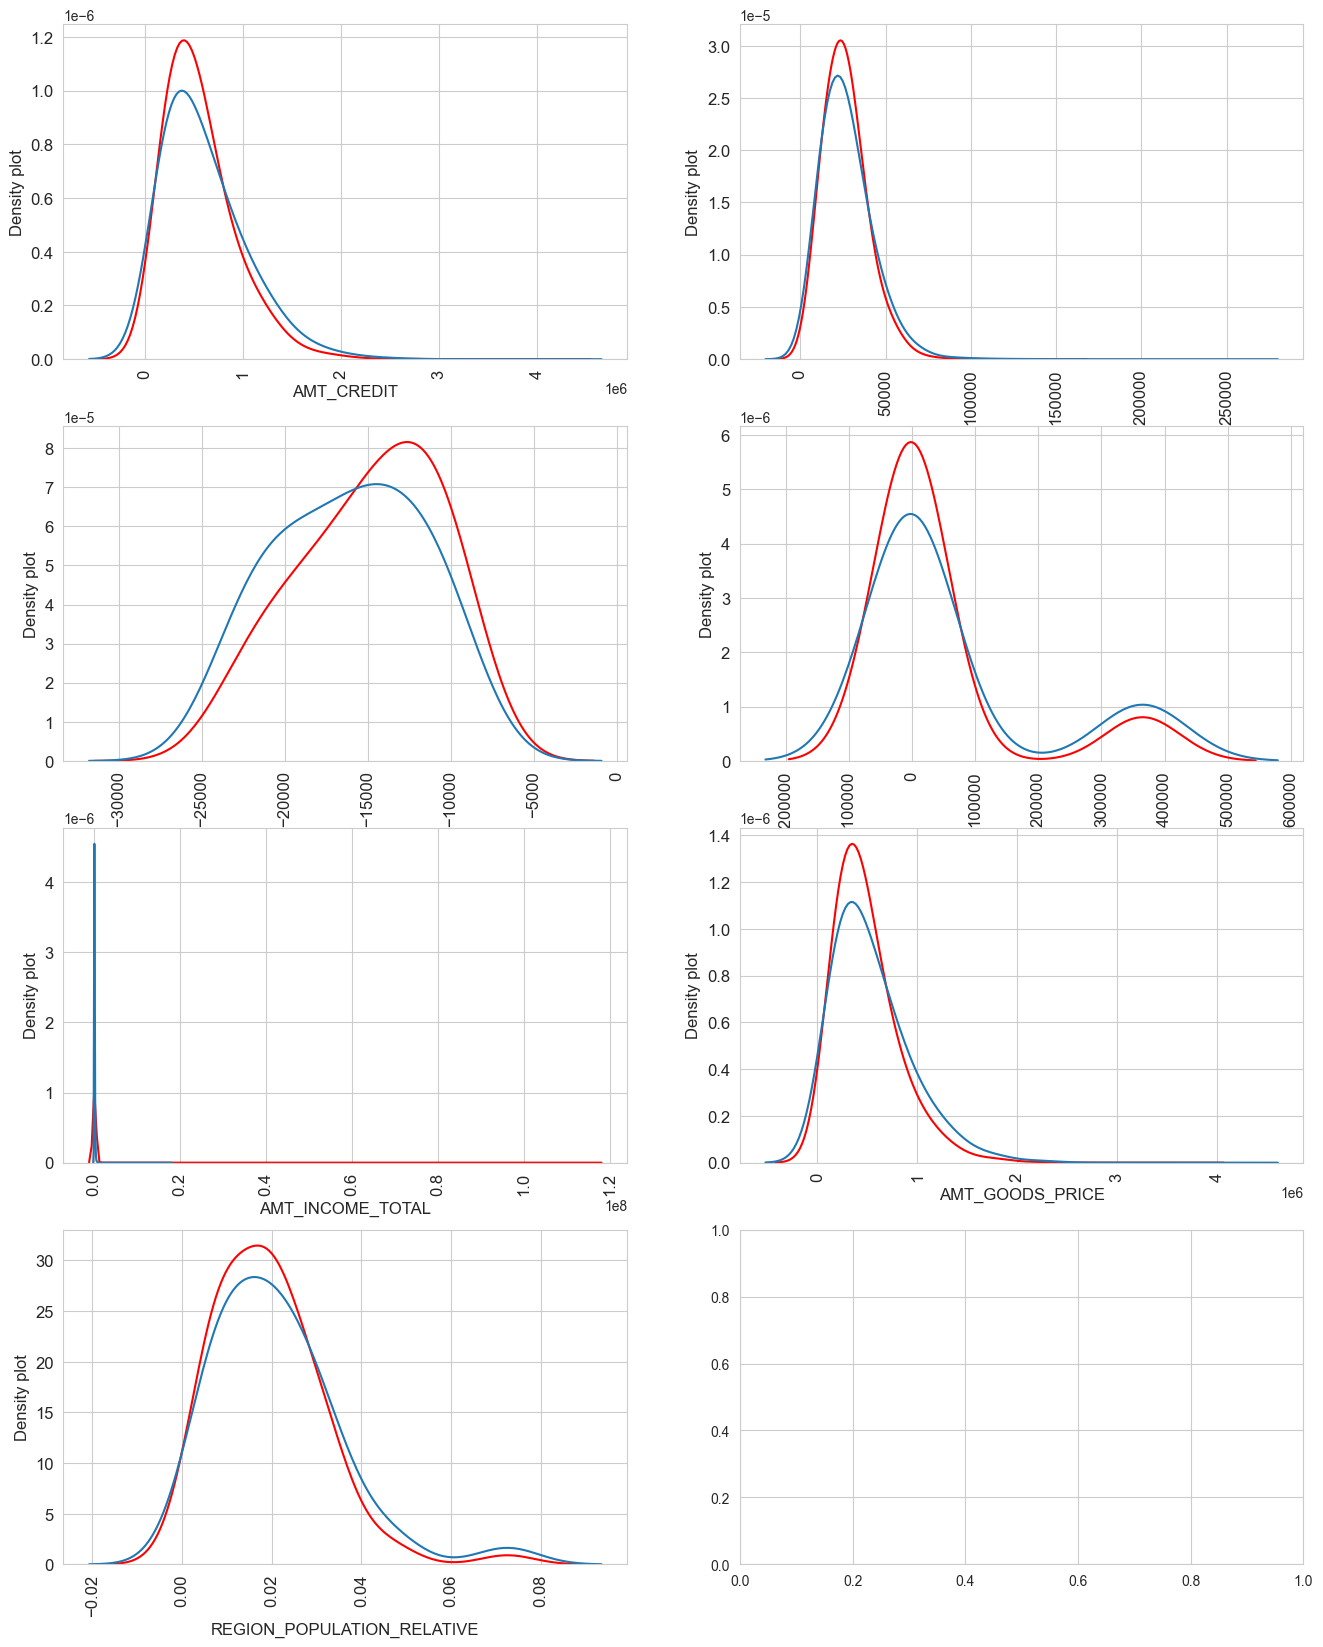

In [65]:
domain_features=['AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE']
plot_distribution(application_train,domain_features)

D'après la distribution des variables : 
- *AMT_CREDIT* : on peut dire qu'un montant élevé de crédit n'augmente pas le défaut de crédit (cela peut s'expliquer par le fait que les banques sont plus strictes sur les dossiers avec montant du crédit élevé donc moins de chance de défauts). Les crédits avec défaut sont plus souvent ceux avec un montant de crédit plus faible.
- *DAYS_BIRTH* : On constante plus de défaut chez les jeunes

### *Corrélations*

In [66]:
EXT_SOURCE_TARGET=['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']
application_train[EXT_SOURCE_TARGET].corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.0,0.214,0.1868,-0.1553
EXT_SOURCE_2,0.214,1.0,0.1092,-0.1605
EXT_SOURCE_3,0.1868,0.1092,1.0,-0.1789
TARGET,-0.1553,-0.1605,-0.1789,1.0


Les variables EXT_SOURCE sont peu corrélées entre elles et elles ont une corrélation négative avec la TARGET.

### Traitement des variables cat binaires en numérique

In [5]:
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
application_test = application_test[application_test['CODE_GENDER'] != 'XNA']
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']: 
    application_train[bin_feature], uniques = pd.factorize(application_train[bin_feature])
    application_test[bin_feature], uniques = pd.factorize(application_test[bin_feature])

In [6]:
application_train.shape

(307507, 122)

### T-TEST

In [17]:
def t_test(df, df_train):
    t_stat_list=[]
    p_val_list=[]
    variable=[]

    for var in df.columns:    
        t_stat, p_val = stats.ttest_ind(df_train[df_train['TARGET'] == 0][var],
                                        df_train[df_train['TARGET'] == 1][var])
        if p_val < 0.05:
            variable.append(var)
            t_stat_list.append(t_stat)
            p_val_list.append(p_val)

    t_test = pd.DataFrame({'variable': variable, 't_stat': t_stat_list, 'p_val': p_val_list})
    return t_test.sort_values(by='p_val',ascending=True)

On fait un t-test pour retenir les variables numériques significatives.
On teste le significativité de la différence entre les moyennes des deux groupes (défaut ou sans défaut).
Si la pvalue est en dessous du seuil de significativité (5%) => on peut conclire qu'il y a une différence significative statistique entre la moyenne des deux groupes.

In [26]:
t_test(df = application_train.select_dtypes(include=[np.number]), df_train = application_train)


,variable,t_stat,p_val
0,TARGET,-inf,0.000
8,DAYS_BIRTH,-43.521,0.000
16,REGION_RATING_CLIENT_W_CITY,-33.831,0.000
15,REGION_RATING_CLIENT,-32.719,0.000
1,CODE_GENDER,30.384,0.000
11,DAYS_ID_PUBLISH,-28.573,0.000
21,REG_CITY_NOT_WORK_CITY,-28.314,0.000
12,FLAG_EMP_PHONE,-25.527,0.000
9,DAYS_EMPLOYED,24.942,0.000
20,REG_CITY_NOT_LIVE_CITY,-24.642,0.000


Selon le t-test, nous identifions ces colonnes comme importantes vis à vis de la variable cible :
DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT, DAYS_ID_PUBLISH REGION_POPULATION_RELATIVE, LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT, FLAG_DOCUMENT_6, FLAG_WORK_PHONE, HOUR_APPR_PROCESS_START, FLAG_PHONE, CNT_CHILDREN, FLAG_DOCUMENT_16, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_8, FLAG_DOCUMENT_18, REG_REGION_NOT_WORK_REGION, FLAG_DOCUMENT_15, REG_REGION_NOT_LIVE_REGION, FLAG_DOCUMENT_2, FLAG_DOCUMENT_9, FLAG_DOCUMENT_11, AMT_INCOME_TOTAL, FLAG_DOCUMENT_21, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY

# Variables Catégorielles

In [12]:
application_train.select_dtypes('O').nunique().sort_values()


NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
HOUSETYPE_MODE                 3
CODE_GENDER                    3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

## Distribution

In [13]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        
        # sns.set_color_codes("deep")
        sns.set_palette("Set3", 10)


        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        
        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        
        
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

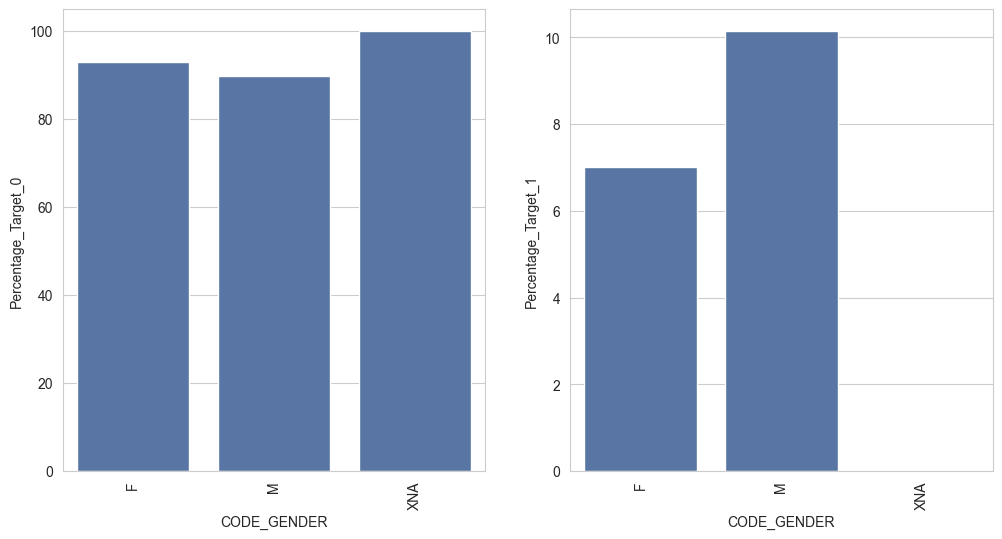

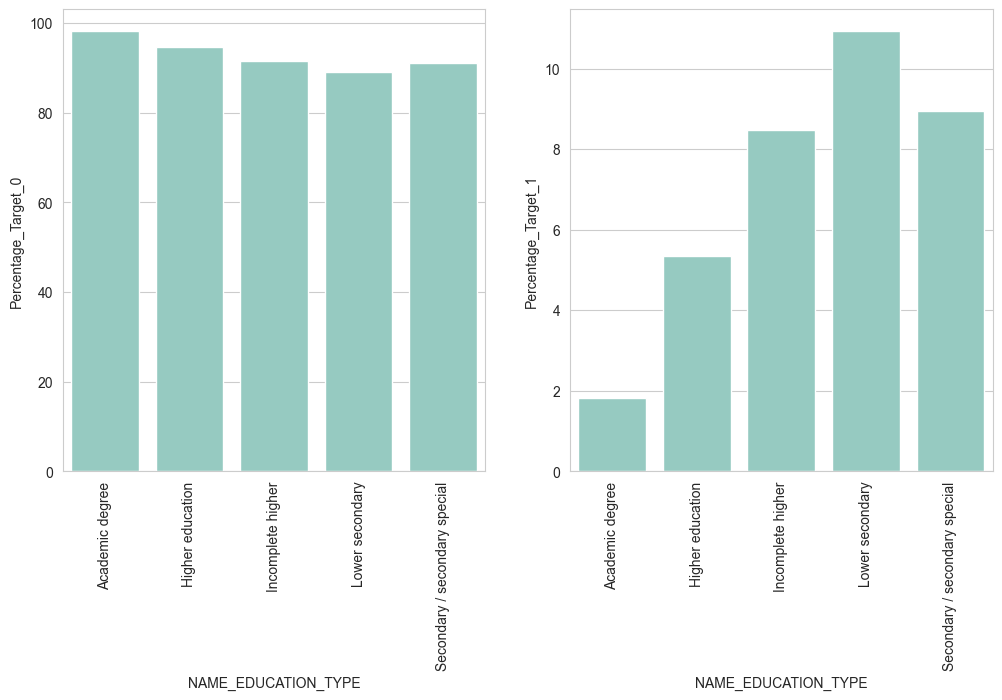

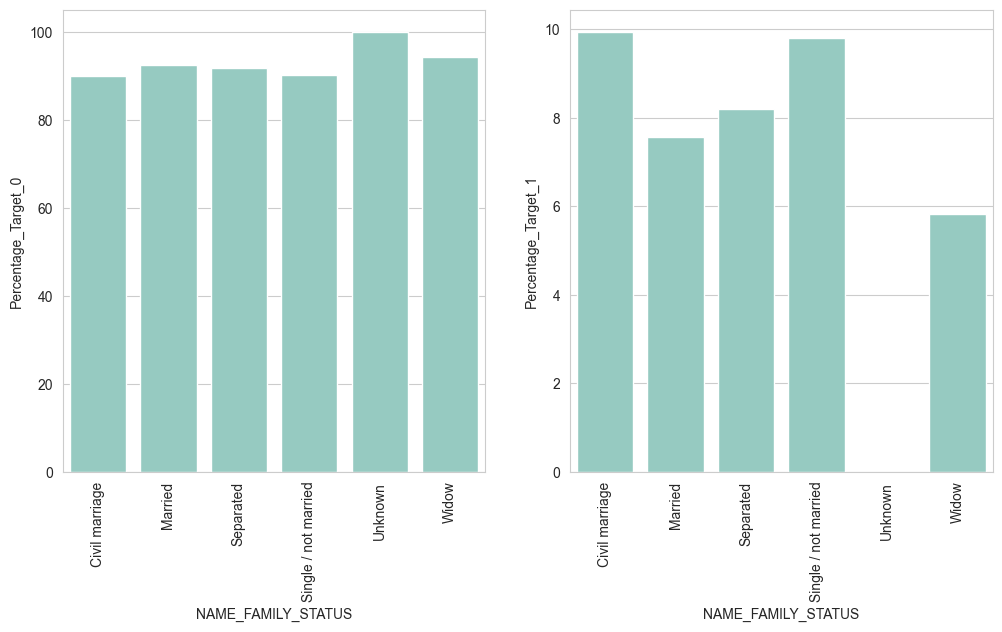

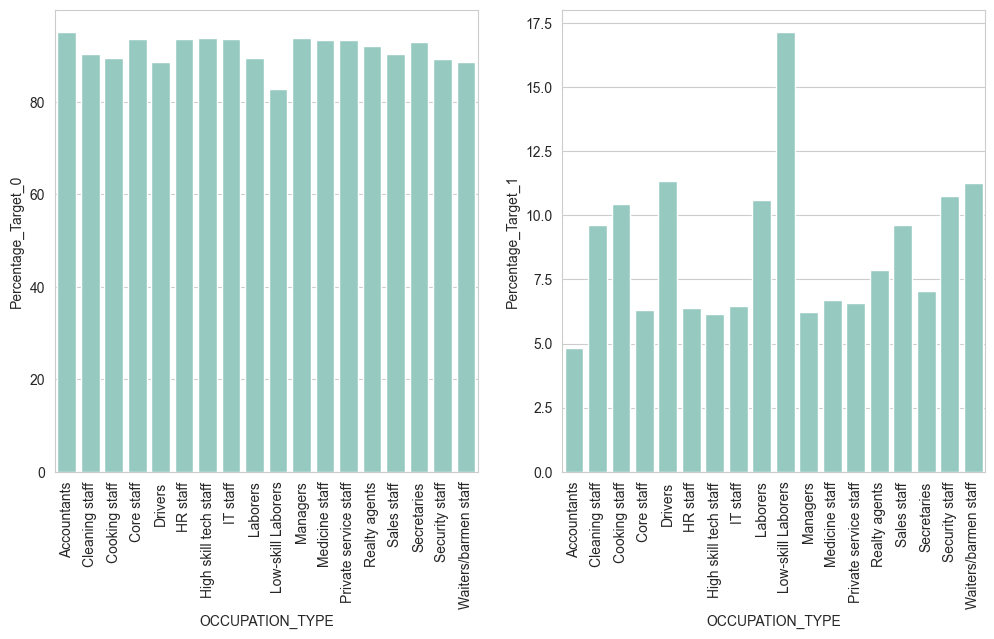

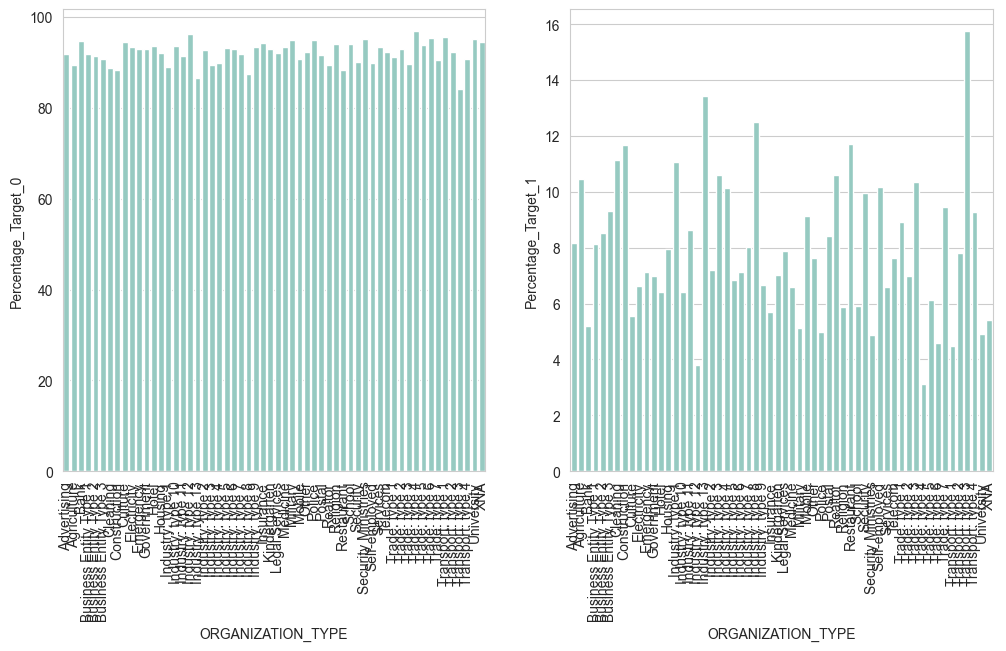

In [77]:
important_features=['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
cat_stats(application_train,important_features)


Observations : 
- CODE_GENDER : Les femmes ont l'air d'avoir moins de défaut de paiement que les hommes et ont légèrement moins de défaut que les hommes.
- NAME_EDUCATION_TYPE : Low education level ont le plus de défaut. On peut observer une différence significative dans la distribution de ceux avec défaut et sans défaut.
- NAME_FAMILY_STATUS : Catégorie avec le plus de défaut => 'Civil Marriage' / Moins de défaut => 'widow'
- OCCUPATION_TYPE : Catégorie avec le plus de défaut => 'Low labores' / Moins de défaut => 'acoountant'

## Chi-2

Test de l'indépendance entre deux évenements.
Plus la Chi-Square value est élevé, plus la feature est dependante de la variable cible.
Si la Chi-Square value est élevé, l'hypothèse d'indépendance est incorrecte.
Deux features indépendantes => Chi-Square value faible.

H0 : Les deux variables sont indépendantes
H1 : Les deux variables ne sont pas indépendantes.


In [14]:
# Perform chi-squared test
def chi2_test(df):
    chi2_stat_list=[]; p_val_list=[]; dof_list=[]; ex_list=[]
    for var in df.columns:
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(application_train['TARGET'], application_train[var]))
        chi2_stat_list.append(chi2_stat); p_val_list.append(p_val); dof_list.append(dof); ex_list.append(ex);
    chi_squared=pd.DataFrame({'variable':df.columns,'dof':dof_list,'chi2_stat':chi2_stat_list,'p_val':p_val_list})
    chi_squared.set_index('variable',inplace=True)
    print(chi_squared.sort_values(by='p_val',ascending=True))

In [30]:
pd.set_option('display.float_format', '{:,.3f}'.format)
chi2_test(application_train.select_dtypes('O'))


                            dof  chi2_stat  p_val
variable                                         
ORGANIZATION_TYPE            57  1,609.237  0.000
OCCUPATION_TYPE              17  1,403.059  0.000
NAME_INCOME_TYPE              7  1,253.552  0.000
NAME_EDUCATION_TYPE           4  1,019.201  0.000
NAME_FAMILY_STATUS            5    504.701  0.000
NAME_HOUSING_TYPE             5    420.544  0.000
NAME_CONTRACT_TYPE            1    292.958  0.000
WALLSMATERIAL_MODE            6    139.239  0.000
HOUSETYPE_MODE                2     27.629  0.000
EMERGENCYSTATE_MODE           1     23.675  0.000
NAME_TYPE_SUITE               6     32.819  0.000
FONDKAPREMONT_MODE            3     16.804  0.001
WEEKDAY_APPR_PROCESS_START    6     15.397  0.017


Au seuil de 1%, si p_value <= 1% on peut rejeter l'hypothèse nulle d'indépendances des variables X et Y. 
Ici la variable WEEKDAY_APPR_PROCESS_START a une p_value > 1%, donc H0 vérifié on peut supprimer cette feature.   

In [31]:
cols_to_drop = ['WEEKDAY_APPR_PROCESS_START', 'WALLSMATERIAL_MODE', 'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE']
application_train.drop(labels=cols_to_drop, axis=1, inplace=True)


In [221]:
application_train.select_dtypes('O')

,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,HOUSETYPE_MODE
0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,Business Entity Type 3,block of flats
1,Cash loans,Family,State servant,Higher education,Married,House / apartment,Core staff,School,block of flats
2,Revolving loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,Government,NaN
3,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,Business Entity Type 3,NaN
4,Cash loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,Religion,NaN
...,...,...,...,...,...,...,...,...,...
307506,Cash loans,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,Services,block of flats
307507,Cash loans,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,XNA,block of flats
307508,Cash loans,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,School,block of flats
307509,Cash loans,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,Business Entity Type 1,block of flats


# Recap EDA


Observations data: 

- Déséquilibre des classes.
- Valeurs manquantes
- Outliers

Insights :
- Le profil de ceux en défaut sont plutôt ceux des hommes et avec niveau d'éducation bas, travail 'low skills' ou jeune avec peu d'expérience professionnelle et ont un score EXT_SOURCE élevé.
- Les crédits en défaut sont souvent avec un montant faible de crédit et une annuité elevé.

# Preprocessing & Feature Engineering

## Traitement Anomalies

In [ ]:
# categorical_columns = application_train.select_dtypes(include='object').columns
# numerical_columns = numeric_relevant_features
# frames_train = [application_train[numerical_columns], application_train[categorical_columns]]
# frames_test = [application_test[np.intersect1d(application_test.columns, numerical_columns)], application_test[categorical_columns]]

In [8]:
df_train = application_train.copy()
df_test = application_test.copy()

In [9]:
# df_train = pd.concat(frames_train, axis = 1)
# df_test =  pd.concat(frames_test, axis = 1)
df_train.shape, df_test.shape

((307507, 122), (48744, 121))

In [10]:
# Cleaning de la data
# Suppresion de l'ID SK_ID_CURR des df application_train et application_test
df_train.drop('SK_ID_CURR',inplace=True,axis=1)
SK_ID_CURR = df_test['SK_ID_CURR']
df_test.drop('SK_ID_CURR',inplace=True,axis=1)

# Remplacement des valeurs en anomalies par NaN
df_train['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
df_test['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
# df_train['CODE_GENDER'].replace('XNA',np.nan,inplace=True)
# df_test['CODE_GENDER'].replace('XNA',np.nan,inplace=True)

In [11]:
# Agrégation des 20 flags documents en une seule variable nombre de documents par ID
FLAG_DOCUMENT=['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21']
df_train['FLAG_DOCUMENT']=df_train[FLAG_DOCUMENT].sum(axis=1)
df_test['FLAG_DOCUMENT']=df_test[FLAG_DOCUMENT].sum(axis=1)
df_train.drop(FLAG_DOCUMENT,axis=1,inplace=True)
df_test.drop(FLAG_DOCUMENT,axis=1,inplace=True)

In [12]:
df_train.shape, df_test.shape

((307507, 102), (48744, 101))

In [ ]:
# Suppression des colonnes AMT_REQ_CREDIT car peu d'impact sur la cible
# AMT_REQ_CREDIT=['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
#                 'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']
# df_train.drop(AMT_REQ_CREDIT,axis=1,inplace=True)
# df_test.drop(AMT_REQ_CREDIT,axis=1,inplace=True)

## Création de Features
Two new features, AGE and YEARS_EMPLOYED, were created to provide additional information about the applicants' age and years of employment, respectively.
also DEBT_TO_INCOME_RATIO: This feature calculates the debt-to-income ratio by dividing the applicant's total credit amount by their total income.

In [13]:
# Age Feature
df_train['AGE']=df_train['DAYS_BIRTH']/(-365)
df_test['AGE']=df_test['DAYS_BIRTH']/(-365)
# MEAN_EXT_SOURCE
df_train['MEAN_EXT_SOURCE'] = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df_test['MEAN_EXT_SOURCE'] = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# Generate YEARS_EMPLOYED
df_train['YEARS_EMPLOYED']=df_train['DAYS_EMPLOYED']/(-365)
df_test['YEARS_EMPLOYED']=df_test['DAYS_EMPLOYED']/(-365)
# DAYS_BIRTH_SQUARED
df_train['DAYS_BIRTH_SQUARED'] = df_train['DAYS_BIRTH'] ** 2
df_test['DAYS_BIRTH_SQUARED'] = df_test['DAYS_BIRTH'] ** 2
# Generate TAUX_ENDETTEMENT 
df_train['TAUX_ENDETTEMENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_test['TAUX_ENDETTEMENT'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']
# Generate RATIO_INCOME_CREDIT 
df_train['RATIO_INCOME_CREDIT'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_CREDIT']
df_test['RATIO_INCOME_CREDIT'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']

In [14]:
df_train.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'FLAG_DOCUMENT', 'AGE', 'MEAN_EXT_SOURCE',
       'YEARS_EMPLOYED', 'DAYS_BIRTH_SQUARED', 'TAUX_ENDETTEMENT',
       'RATIO_INCOME_CREDIT'],
      dtype='object', length=108)

In [15]:
new_numeric_features=['AGE','YEARS_EMPLOYED','TAUX_ENDETTEMENT','RATIO_INCOME_CREDIT','DAYS_BIRTH_SQUARED']

In [18]:
t_test(df = df_train[new_numeric_features], df_train = df_train)

,variable,t_stat,p_val
0,AGE,43.521149,0.000000
2,DAYS_BIRTH_SQUARED,42.643816,0.000000
1,TAUX_ENDETTEMENT,4.286303,0.000018


## Traitement des valeurs manquantes

D'après l'EDA, il y a 67 colonnes avec différentes proportions de valeurs manquantes allant de 0 à 720%.
La stratégie adoptée pour imputer les valeurs manquantes :
- **Variables Numériques** : Suppression des features avec plus de 50% de valeurs manquantes et imputation par la médiane pour les autres
- **Variables Catégorielles** : Encoding et suppression des dummy NA

In [19]:
# Identification des variables numériques  avec plus de 60% de NA
df_train_numeric= df_train.select_dtypes(include=['number'])
missings =df_train_numeric.loc[:,df_train_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
missings.columns

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

### Suppression des features avec plus de 60% NaN

In [20]:
# Suppression des features avec beaucoup de NA
df_train.drop(highly_missing_features,axis=1,inplace=True)
df_test.drop(highly_missing_features,axis=1,inplace=True)

In [21]:
df_train.shape, df_test.shape

((307507, 92), (48744, 91))

### Imputation par la médiane

In [22]:
target = df_train['TARGET']
features_train = df_train.drop('TARGET', axis=1)
features_cols = features_train.columns
# Impute numerical features using mean imputation
numeric_imputer = SimpleImputer(strategy='median')
numeric_features_train = features_train.select_dtypes(include='number')
imputed_numeric_features_train = numeric_imputer.fit_transform(numeric_features_train)
numeric_features_test = df_test[features_cols.tolist()].select_dtypes(include='number')
imputed_numeric_features_test = numeric_imputer.transform(numeric_features_test)

In [23]:
features_train.shape, target.shape

((307507, 91), (307507,))

# Encoding variables catégorielles + suppression des catégories manquantes

On applique un one-hot encoding sans généré une variable pour les catégories NaN puis on rassemble les variables numériques et catégorielles.

In [24]:
features_train.select_dtypes('O').nunique().sort_values()


NAME_CONTRACT_TYPE             2
EMERGENCYSTATE_MODE            2
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

In [25]:
categorical_features_train = features_train.select_dtypes(include='object')


In [ ]:
# categorical_features_train.drop(['ORGANIZATION_TYPE', 'NAME_TYPE_SUITE'], axis=1, inplace=True)


In [26]:
categorical_features_train

,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


In [27]:
dummy_categorical_features_train = pd.get_dummies(categorical_features_train,dummy_na=False)
# Concaténation imputed numerical et categorical features Train
imputed_features_train = pd.concat([
    pd.DataFrame(imputed_numeric_features_train, columns=numeric_features_train.columns).reset_index(drop = True),
    dummy_categorical_features_train.reset_index(drop = True)],
    axis=1
)

In [28]:
# Concaténation imputed categorical features Test avec mode imputation et one-hot encoding
categorical_features_test = df_test.select_dtypes(include='object')
# categorical_features_test.drop(['ORGANIZATION_TYPE', 'NAME_TYPE_SUITE'], axis=1, inplace=True)
dummy_categorical_features_test = pd.get_dummies(categorical_features_test,dummy_na=False)

# Concatenate imputed numerical and categorical features
imputed_features_test = pd.concat([
    pd.DataFrame(imputed_numeric_features_test, columns=numeric_features_test.columns).reset_index(drop = True),
    dummy_categorical_features_test.reset_index(drop = True)],
    axis=1
)

In [29]:
imputed_features_train.drop('NAME_INCOME_TYPE_Maternity leave',axis=1,inplace=True)
imputed_features_train.drop('NAME_FAMILY_STATUS_Unknown',axis=1,inplace=True)

In [30]:
imputed_features_train.shape, imputed_features_test.shape

((307507, 209), (48744, 209))

# Export des datasets nettoyées

In [31]:
df_train_clean = pd.concat([imputed_features_train, target], axis=1)
df_train_clean.to_csv('data/df_train__200.csv', encoding='utf-8', index=None)
imputed_features_test.to_csv('data/df_test__200.csv', encoding='utf-8', index=None)

# Modèle

In [32]:
def get_model_metrics(model_name: str, y_test, y_pred, y_prob):
    metrics = {
        "model_name": model_name,
        "f2_score": fbeta_score(y_test, y_pred, beta=10),
        "accuracy_score": accuracy_score(y_test, y_pred), # Utilisation de accuracy_score
        "recall": recall_score(y_true=y_test, y_pred=y_pred),
        "f1_score": f1_score(y_true=y_test, y_pred=y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
    }
    print(f"F1-score: {metrics['f1_score']}")
    print(f"F2-score : {metrics['f2_score']}")
    print(f"ROC AUC : {metrics['roc_auc']}")
    print(f"accuracy_score : {metrics['accuracy_score']}")
    print(f"Recall : {metrics['recall']}")
    print('*' * 20)
    return metrics

In [33]:
def log_model_mlflow(x_train, metrics_dict, model, model_name, tag_model:None):
    with mlflow.start_run():
        params = {
            "nthread":6,
            "n_estimators":10000,
            "learning_rate":0.02,
            "num_leaves":34,
            "colsample_bytree":0.9497036,
            "subsample":0.8715623,
            "max_depth":8,
            "reg_alpha":0.041545473,
            "reg_lambda":0.0735294,
            "min_split_gain":0.0222415,
            "min_child_weight":39.3259775,
            "silent":-1,
            "verbose":-1
        }
        mlflow.log_params(params)

        # Log the metric
        # mlflow.log_metric(metric_name, metric)
        mlflow.log_metric('f2_score', metrics_dict['f2_score'])
        mlflow.log_metric('roc_auc', metrics_dict['roc_auc'])

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", model_name)
        mlflow.set_tag("Model Info", tag_model)

        # Infer the model signature
        signature = infer_signature(x_train, model.predict(x_train))
        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=model_name,
            signature=signature,
            registered_model_name=model_name,
        )

## SetUp MLFlow

In [40]:
# Set MLflow Experiment ---------------------------------------------------------
mlflow.set_tracking_uri(uri="http://localhost:8080")
# mlflow.set_experiment("credit_scoring_experiment__80_features")
# mlflow.set_experiment("credit_scoring_experiment__80FeaturesAllRows")
mlflow.set_experiment("credit_scoring_experiment__200FeaturesAllRows")

2024/12/16 20:26:16 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring_experiment__200FeaturesAllRows' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/338490292909216361', creation_time=1734377176495, experiment_id='338490292909216361', last_update_time=1734377176495, lifecycle_stage='active', name='credit_scoring_experiment__200FeaturesAllRows', tags={}>

# Sélection de modèles

In [35]:
X = imputed_features_train.copy()
y = target

### Sous-échantillon du dataframe

In [437]:
df_subset = pd.concat([X, y], axis=1)
df_subset = df_subset.head(10000)
df_subset.shape

(10000, 81)

In [438]:
X = df_subset.drop('TARGET', axis=1)
y = df_subset['TARGET']

In [439]:
X.shape, y.shape

((10000, 80), (10000,))

### Splitting Train and Test Sets

In [36]:
#splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=27)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230630, 209), (76877, 209), (230630,), (76877,))

## Scaling

In [38]:
# Scaling data
scaler = MinMaxScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Sélection de Modèles

## Dummy Classifier

In [39]:
from sklearn.dummy import DummyClassifier
# Scaling data
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_scaled, y_train)
y_pred__dummy = dummy_clf.predict(X_test_scaled)
y_pred_train__dummy = dummy_clf.predict(X_train_scaled)
# Prédire les probabilités
y_prob__dummy = dummy_clf.predict_proba(X_test_scaled)[:, 1]
y_prob_train__dummy = dummy_clf.predict_proba(X_train_scaled)[:, 1]

print('*' * 20)
print('Metrics Test')
metrics_dummy = get_model_metrics('DummyClassifier__test', y_test, y_pred__dummy, y_prob__dummy)
print('Metrics Train')
metrics_dummy__train = get_model_metrics('DummyClassifier__train', y_train, y_pred_train__dummy, y_prob_train__dummy)

********************
Metrics Test
F1-score: 0.0
F2-score : 0.0
ROC AUC : 0.5
accuracy_score : 0.9192736449133031
Recall : 0.0
********************
Metrics Train
F1-score: 0.0
F2-score : 0.0
ROC AUC : 0.5
accuracy_score : 0.9192689589385596
Recall : 0.0
********************


In [41]:
log_model_mlflow(X_train_scaled, metrics_dummy, dummy_clf, "DummyClassifier", tag_model="Baseline")

Registered model 'DummyClassifier' already exists. Creating a new version of this model...
2024/12/16 20:26:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier, version 5
Created version '5' of model 'DummyClassifier'.
2024/12/16 20:26:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-roo-547 at: http://localhost:8080/#/experiments/338490292909216361/runs/41ef024e8b1c47daa9fff560749216c6.
2024/12/16 20:26:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/338490292909216361.


## Logistic Regression

In [42]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=0).fit(X_train_scaled, y_train)
y_pred__lr = lr.predict(X_test_scaled)
y_pred_train__lr = lr.predict(X_train_scaled)
y_prob__lr = lr.predict_proba(X_test_scaled)[:,1]
y_prob_train__lr = lr.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_LR = get_model_metrics(f'LogisticRegression__test', y_test, y_pred__lr, y_prob__lr)
print('Metrics Train')
metrics_LR_train = get_model_metrics(f'LogisticRegression__train', y_train, y_pred_train__lr, y_prob_train__lr)

********************
Metrics Test
F1-score: 0.2574354571656344
F2-score : 0.6553211088580049
ROC AUC : 0.7454985419379857
accuracy_score : 0.6849773014035407
Recall : 0.676442152755398
********************
Metrics Train
F1-score: 0.2584618537685095
F2-score : 0.656259113199984
ROC AUC : 0.748030538548427
accuracy_score : 0.686237696743702
Recall : 0.6773188678231914
********************


In [43]:
log_model_mlflow(X_train_scaled, metrics_LR, lr, "LogisticRegression", tag_model = None)

Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/12/16 20:27:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 2
Created version '2' of model 'LogisticRegression'.
2024/12/16 20:27:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-grub-74 at: http://localhost:8080/#/experiments/338490292909216361/runs/07c7766380864828bf5801ce95a58df8.
2024/12/16 20:27:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/338490292909216361.


## Random Forest

In [44]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X_train_scaled, y_train)
y_pred__rf = rf.predict(X_test_scaled)
y_pred_train__rf = rf.predict(X_train_scaled)
y_prob__rf = rf.predict_proba(X_test_scaled)[:,1]
y_prob_train__rf = rf.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_RF = get_model_metrics(f'RandomForestClassifier__test', y_test, y_pred__rf, y_prob__rf)
print('Metrics Train')
metrics_RF_train = get_model_metrics(f'RandomForestClassifier__train', y_train, y_pred_train__rf, y_prob_train__rf)


********************
Metrics Test
F1-score: 0.006088767825668963
F2-score : 0.003091994489514771
ROC AUC : 0.7221109463704242
accuracy_score : 0.9193126682883047
Recall : 0.003061553335481792
********************
Metrics Train
F1-score: 0.999731384979048
F2-score : 0.9994682290805309
ROC AUC : 1.0
accuracy_score : 0.9999566405064388
Recall : 0.9994629142274021
********************


In [45]:
log_model_mlflow(X_train_scaled, metrics_RF, rf, "RandomForestClassifier", tag_model = None)

Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2024/12/16 20:33:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 4
Created version '4' of model 'RandomForestClassifier'.
2024/12/16 20:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-ape-720 at: http://localhost:8080/#/experiments/338490292909216361/runs/18f6d02951014589a8d2c5b86c29fb7f.
2024/12/16 20:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/338490292909216361.


## LGBM Classifier

In [46]:
# LGBM Classifier
clf = LGBMClassifier(objective= 'binary', class_weight="balanced").fit(X_train_scaled, y_train)
y_pred__clf = clf.predict(X_test_scaled)
y_pred_train__clf = clf.predict(X_train_scaled)
y_prob__clf = clf.predict_proba(X_test_scaled)[:,1]
y_prob_train__clf = clf.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_LGBM = get_model_metrics(f'LGBMClassifier__test', y_test, y_pred__clf, y_prob__clf)
print('Metrics Train')
metrics_LGBM_train = get_model_metrics(f'LGBMClassifier__train', y_train, y_pred_train__clf, y_prob_train__clf)

[LightGBM] [Info] Number of positive: 18619, number of negative: 212011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10351
[LightGBM] [Info] Number of data points in the train set: 230630, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
********************
Metrics Test
F1-score: 0.26890429598911425
F2-score : 0.6495831137835911
ROC AUC : 0.7546296751675696
accuracy_score : 0.7064661732377694
Recall : 0.6687077022236545
********************
Metrics Train
F1-score: 0.2909390659233389
F2-score : 0.6998846280429806
ROC AUC : 0.7987058479657075
accuracy_score : 0.7165416467935655
Recall : 0.7203394382082818
********************


In [47]:
log_model_mlflow(X_train_scaled, metrics_LGBM, clf, "LGBMClassifier", tag_model = None)

Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2024/12/16 20:35:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 4
Created version '4' of model 'LGBMClassifier'.
2024/12/16 20:35:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run invincible-smelt-125 at: http://localhost:8080/#/experiments/338490292909216361/runs/e07bc68e72dc4bd7bf4130c836a9b5fe.
2024/12/16 20:35:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/338490292909216361.


## Gradient Boosting

In [48]:
# Create an instance of the GradientBoostingClassifier class
gbc = GradientBoostingClassifier(n_estimators=100, subsample=0.2, random_state=42, verbose = 1).fit(X_train_scaled, y_train)

y_pred__gbc = gbc.predict(X_test_scaled)
y_pred_train__gbc = gbc.predict(X_train_scaled)
y_prob__gbc = gbc.predict_proba(X_test_scaled)[:,1]
y_prob_train__gbc = gbc.predict_proba(X_train_scaled)[:,1]

print('*' * 20)
print('Metrics Test')
metrics_GBC = get_model_metrics(f'GradientBoostingClassifier__test', y_test, y_pred__gbc, y_prob__gbc)
print('Metrics Train')
metrics_GBC_train = get_model_metrics(f'GradientBoostingClassifier__train', y_train, y_pred_train__gbc, y_prob_train__gbc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5403           0.0102            1.24m
         2           0.5471           0.0115            1.18m
         3           0.5478           0.0075            1.17m
         4           0.5328           0.0018            1.16m
         5           0.5275           0.0037            1.16m
         6           0.5221           0.0027            1.18m
         7           0.5239           0.0036            1.24m
         8           0.5156           0.0006            1.32m
         9           0.5223           0.0039            1.36m
        10           0.5105          -0.0009            1.39m
        20           0.5099           0.0018            1.36m
        30           0.4987           0.0007            1.18m
        40           0.5021          -0.0014           59.82s
        50           0.5023           0.0036           48.70s
        60           0.4951          -0.0025           38.23s
       

In [49]:
log_model_mlflow(X_train_scaled, metrics_GBC, gbc, "GradientBoostingClassifier", tag_model = None)

Registered model 'GradientBoostingClassifier' already exists. Creating a new version of this model...
2024/12/16 20:37:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoostingClassifier, version 6
Created version '6' of model 'GradientBoostingClassifier'.
2024/12/16 20:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-skink-770 at: http://localhost:8080/#/experiments/338490292909216361/runs/ccfbd09474024652b78901158c713775.
2024/12/16 20:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/338490292909216361.


## Recap Metriques Modèles

In [50]:
df_model_metrics = pd.DataFrame([metrics_dummy])
# df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_train])], join='inner', ignore_index=True)

list_metrics = [
    metrics_dummy__train,
    metrics_LR,
    metrics_LR_train,
    metrics_RF,
    metrics_RF_train,
    metrics_LGBM,
    metrics_LGBM_train,
    metrics_GBC,
    metrics_GBC_train,
]

for m in list_metrics :
    df_model_metrics = pd.concat([df_model_metrics, pd.DataFrame([m])], join='inner', ignore_index=True)


In [152]:
df_model_metrics.sort_values('roc_auc', ascending=False)

,model_name,f2_score,accuracy_score,recall,f1_score,roc_auc
5,RandomForestClassifier__train,0.999,1.000,0.999,1.000,1.000
7,LGBMClassifier__train,0.696,0.712,0.717,0.287,0.792
6,LGBMClassifier__test,0.653,0.701,0.673,0.266,0.753
9,GradientBoostingClassifier__train,0.019,0.920,0.019,0.036,0.751
8,GradientBoostingClassifier__test,0.018,0.920,0.018,0.035,0.745
3,LogisticRegression__train,0.653,0.685,0.674,0.257,0.744
2,LogisticRegression__test,0.651,0.683,0.672,0.255,0.743
4,RandomForestClassifier__test,0.003,0.919,0.003,0.005,0.723
1,DummyClassifier__train,0.000,0.919,0.000,0.000,0.500
0,DummyClassifier__test,0.000,0.919,0.000,0.000,0.500


==>  Choix du modèle LGBM Classifier

# Simple estimators


In [ ]:
# Define class weights
class_weights = {0: 1, 1: 9}

simple_estimators = {
    'Logistic Regression':LogisticRegression(),
    # 'Decision Tree':DecisionTreeClassifier(),
    # 'Linear Discriminant Analysys': LinearDiscriminantAnalysis()
}

- Application du SMOTE Oversampling technique pour équilibrer les classes dans le jeu de données Train, puis scaling des features avec MinMaxScaler
- Utilisation du RFE (Recursive Feature Elimation) pour sélectionner les features les plus importantes pour entraîner le modèle.

In [ ]:
def training_simple_models(estimators, df_metrics):
    for name, model in estimators.items():
        print("Running " + name)

        # Apply SMOTE oversampling to the training data
        smote = SMOTE()
        X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
        
        # Scaling data
        scaler = MinMaxScaler()
        X_train_scaled= scaler.fit_transform(X_train_smt)
        X_test_scaled=scaler.transform(X_test)
        
        # Perform Recursive Feature Elimination (RFE)
        selector = RFE(estimator=model)
        X_train_selected = selector.fit_transform(X_train_scaled, y_train_smt)
        X_test_selected = selector.transform(X_test_scaled)
        
        # Train the model on the selected features
        model_fitted = model.fit(X_train_selected, y_train_smt)
        
        # Make predictions on the test data
        # y_pred = model.predict_proba(X_test_selected)[:, 1]
        y_pred = model_fitted.predict(X_test_selected)
        y_pred_train = model_fitted.predict(X_train_selected)   
        # Prédire les probabilités
        y_prob = model_fitted.predict_proba(X_test_selected)[:, 1]
        y_prob_train = model_fitted.predict_proba(X_train_selected)[:, 1]

        # Calculate and print the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("roc_auc:", roc_auc)
        print('*' * 20)

        metrics = get_model_metrics(f'{name}__test', y_test, y_pred, y_prob)
        metrics_train = get_model_metrics(f'{name}__train', y_train_smt, y_pred_train, y_prob_train)

        df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics])], join='inner', ignore_index=True)
        df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_train])], join='inner', ignore_index=True)

        # log_model_mlflow(X_train_selected, metrics, model_fitted, name, tag_model="SimpleEstimator")

    return df_model_metrics

In [120]:
y_train.shape, y_pred_train.shape, X_train_scaled.shape,X_train_smt.shape

((230630,), (424022,), (424022, 80), (424022, 80))

In [107]:
# Set MLflow Experiment ---------------------------------------------------------
mlflow.set_tracking_uri(uri="http://localhost:8080")
# mlflow.set_experiment("credit_scoring_experiment__80_features")
mlflow.set_experiment("credit_scoring_experiment__80FeaturesAllRows")

2024/12/13 18:36:54 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring_experiment__80FeaturesAllRows' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/666065718232572421', creation_time=1734111414233, experiment_id='666065718232572421', last_update_time=1734111414233, lifecycle_stage='active', name='credit_scoring_experiment__80FeaturesAllRows', tags={}>

In [131]:
%timeit training_simple_models(simple_estimators, df_model_metrics)

Running Logistic Regression
roc_auc: 0.5282770680402902
********************
Le ROC AUC est de: 0.6754464922320302
Le ROC AUC est de: 0.9604990326693496
Running Decision Tree
roc_auc: 0.5400804861595728
********************
Le recall est de: 0.17757009345794392
Le F1-score est de: 0.1552987598647125
Le ROC AUC est de: 0.5400804861595728
Le F2-score est de: 0.17706725889536198
Le recall est de: 1.0
Le F1-score est de: 1.0
Le ROC AUC est de: 1.0
Le F2-score est de: 1.0
Running Logistic Regression
roc_auc: 0.5345917365482269
********************
Le ROC AUC est de: 0.6879596987603471
Le ROC AUC est de: 0.9603449232617518
Running Decision Tree
roc_auc: 0.5373069766991575
********************
Le recall est de: 0.17257492748952627
Le F1-score est de: 0.1508450704225352
Le ROC AUC est de: 0.5373069766991575
Le F2-score est de: 0.17208404789100756
Le recall est de: 1.0
Le F1-score est de: 1.0
Le ROC AUC est de: 1.0
Le F2-score est de: 1.0
Running Logistic Regression
roc_auc: 0.5368133930562291


KeyboardInterrupt: 

In [106]:
df_model_metrics

,model_name,f2_score,recall,f1_score,roc_auc
0,DummyClassifier,0.000,0.000,0.000,0.500


### Méthode d'Ensemble

In [ ]:
# Create an instance of the GradientBoostingClassifier class
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.2, random_state=42, verbose = 1)

# Fit the model to the training data
clf_fitted = clf.fit(X_train, y_train)

# Make predictions on the test data
# y_pred = clf.predict_proba(X_test)[:,1]
y_prob = clf_fitted.predict_proba(X_test)[:,1]
y_pred = clf_fitted.predict(X_test)
roc_GBC=roc_auc_score(y_test, y_prob)
print(roc_GBC)

metrics_GBC = get_model_metrics(clf_fitted, y_test, y_pred, y_prob)
log_model_mlflow(X_train, metrics_GBC, clf_fitted, "GradientBoostingClassifier", tag_model="Ensemble Model")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5036           0.0113            1.44s
         2           0.5363           0.0194            0.93s
         3           0.5459           0.0107            1.14s
         4           0.5164          -0.0012            1.22s
         5           0.4833          -0.0029            0.96s
         6           0.4635           0.0013            1.12s
         7           0.4680           0.0059            1.11s
         8           0.4780           0.0083            1.09s
         9           0.4576          -0.0017            1.04s
        10           0.4662           0.0060            1.05s
        20           0.5099           0.0128            0.91s
        30           0.5012           0.0031            0.80s
        40           0.4472           0.0014            0.68s
        50           0.4300           0.0022            0.56s
        60           0.4522          -0.0085            0.45s
       

Registered model 'GradientBoostingClassifier' already exists. Creating a new version of this model...
2024/12/12 23:15:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoostingClassifier, version 4
Created version '4' of model 'GradientBoostingClassifier'.
2024/12/12 23:15:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-worm-87 at: http://localhost:8080/#/experiments/495850407925590538/runs/14333ed945944459902a08a4493b0cc5.
2024/12/12 23:15:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/495850407925590538.


In [ ]:
# Running Xgboost
# Define class weights
class_weights = {0: 1, 1: 9}

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test_scaled)

# Create an instance of the XGBClassifier class
xgb = XGBClassifier(n_estimators=100, subsample=0.4, random_state=1, scale_pos_weight=class_weights[1]/class_weights[0])

# Fit the model to the training data
xgb_fitted = xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
# y_pred = xgb.predict_proba(X_test_scaled)[:,1]
y_prob = xgb_fitted.predict_proba(X_test_scaled)[:,1]
y_pred = xgb_fitted.predict(X_test_scaled)
roc_xgb = roc_auc_score(y_test, y_prob)
print(roc_xgb)
metrics_xgb = get_model_metrics(xgb_fitted, y_test, y_pred, y_prob)
log_model_mlflow(X_train_scaled, metrics_xgb, clf_fitted, "XGBClassifier", tag_model="Ensemble Model")

0.677066102770898
Le ROC AUC est de: 0.677066102770898


Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2024/12/12 23:14:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 3
Created version '3' of model 'XGBClassifier'.
2024/12/12 23:14:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-lark-877 at: http://localhost:8080/#/experiments/495850407925590538/runs/d47e9f6d024d42c4a73a80c88462cc82.
2024/12/12 23:14:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/495850407925590538.


In [ ]:
# Running Random Forest 
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_100_fitted = rfc_100.fit(X_train, y_train)
# y_pred_100 = rfc_100_fitted.predict_proba(X_test)[:,1]
y_prod_100 = rfc_100_fitted.predict_proba(X_test)[:,1]
y_pred_100 = rfc_100_fitted.predict(X_test)
print('Model auc score with 100 decision-trees : {0:0.4f}'. format(roc_auc_score(y_test, y_prod_100)))

metrics_rfc_100 = get_model_metrics(rfc_100_fitted, y_test, y_pred_100, y_prod_100)
log_model_mlflow(X_train, metrics_rfc_100, rfc_100_fitted, "RandomForestClassifier_100", tag_model="Ensemble Model")

Model auc score with 100 decision-trees : 0.7411
Le ROC AUC est de: 0.7410553821943653


Successfully registered model 'RandomForestClassifier_100'.
2024/12/12 23:20:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier_100, version 1
Created version '1' of model 'RandomForestClassifier_100'.
2024/12/12 23:20:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run classy-shad-922 at: http://localhost:8080/#/experiments/495850407925590538/runs/c86c389cbe7f4fa888d5046b6e5ab8fa.
2024/12/12 23:20:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/495850407925590538.


# Tuning Model

## GridSearchCV on LGBM Classifier

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from multiprocessing import cpu_count
# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('s', SMOTE(random_state=1)),
    ('r', RFE(estimator=LGBMClassifier(objective= 'binary'))),
    ('m', LGBMClassifier(objective= 'binary'))
])

# Define the parameter grid
param_grid = {
    'r__n_features_to_select': [40, 50, 70],  # RFE hyperparameter
    'r__step': [3,5], # RFE hyperparameter
    's__sampling_strategy': ['auto', 0.5],  # SMOTE : ratio entre l'échantillone dans la classe minoritaire et la classe majoritaire
    # 'm__penalty': ['l1', 'l2'], # Pénalité quand le modèle se trompe
    # 'm__C': [0.001,0.01, 0.1], # Plus ce paramètre est faible, plus la régularisation de la fontion de coût est élevée.
    'm__max_iter': [200, 300] # Nombre maximum d'itération pour que le solver converge
}
# n_estimators = 500, 1000 
# learning_rate

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)

# Effectuer une recherche par grille
grid_search_LGBM = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',  # Métrique d'évaluation
    cv=cv,
    verbose=0,
    n_jobs=cpu_count()
)

# Lancer la recherche sur les données (X, y)
lgbm_tuned_fitted = grid_search_LGBM.fit(X_train, y_train)
y_prob__lgbm_tuned = lgbm_tuned_fitted.predict_proba(X_test)[:,1]
y_pred__lgbm_tuned = lgbm_tuned_fitted.predict(X_test)

y_prob_train__lgbm_tuned = lgbm_tuned_fitted.predict_proba(X_train)[:,1]
y_pred_train__lgbm_tuned = lgbm_tuned_fitted.predict(X_train)
# Afficher les meilleurs paramètres
print("Meilleurs paramètres :", grid_search_LGBM.best_params_)
print("Meilleur score AUC :", grid_search_LGBM.best_score_)

print('*' * 20)
print('Metrics Test')
metrics_LGBM_tuned = get_model_metrics(f'LGBMClassifier_tuned__test', y_test, y_pred__lgbm_tuned, y_prob__lgbm_tuned)
print('Metrics Train')
metrics_LGBM_train_tuned = get_model_metrics(f'LGBMClassifier_tuned__train', y_train, y_pred_train__lgbm_tuned, y_prob_train__lgbm_tuned)

KeyboardInterrupt: 

In [168]:
log_model_mlflow(X_train, metrics_LGBM_tuned, lgbm_tuned_fitted, "LGBMClassifierTuned", tag_model="Model Tuned")

Successfully registered model 'LGBMClassifierTuned'.
2024/12/15 00:15:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifierTuned, version 1
Created version '1' of model 'LGBMClassifierTuned'.
2024/12/15 00:15:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-whale-164 at: http://localhost:8080/#/experiments/666065718232572421/runs/3689d6e5538e45728d84f5aaa8a6da2d.
2024/12/15 00:15:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/666065718232572421.


In [194]:
best_LGBM = grid_search_LGBM.best_estimator_
# Print the best parameters and best score
print("Best Parameters:", grid_search_LGBM.best_params_)
print("Best Score:", grid_search_LGBM.best_score_)

Best Parameters: {'m__max_iter': 200, 'r__n_features_to_select': 50, 'r__step': 5}
Best Score: 0.7528211989623084


## Evaluation Modèle

In [ ]:
def roc_curve__confusion_matrix(model):
    from sklearn.metrics import roc_curve, auc
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train  = model.predict_proba(X_train)[:, 1]
    prediction=model.predict(X_test)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()

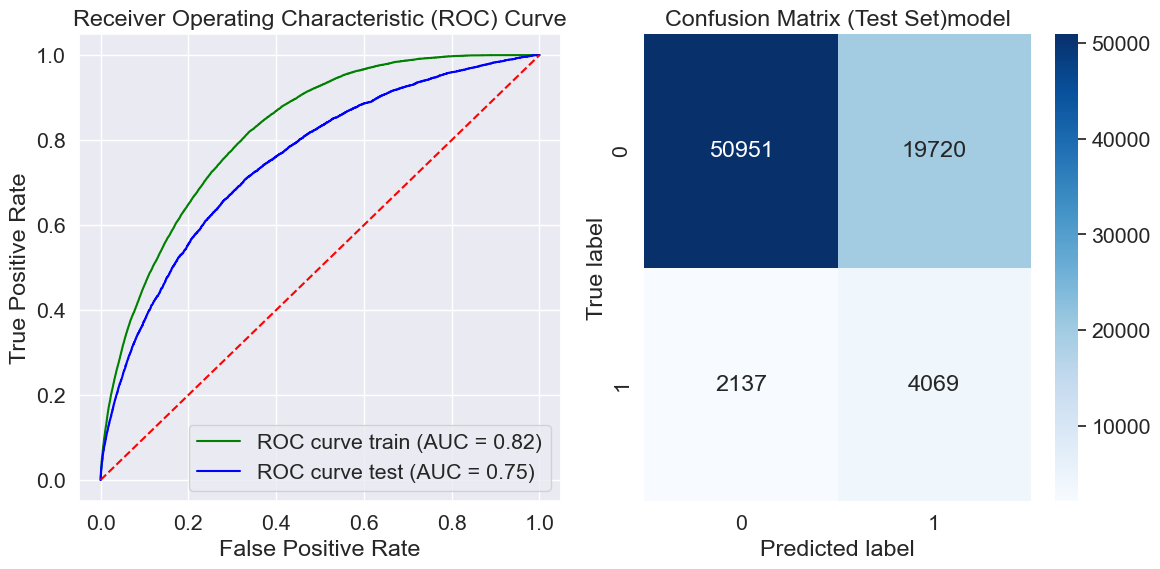

In [195]:
roc_curve__confusion_matrix(best_LGBM)


In [253]:
def feature_importance(model):  
    
    # Extract features importance from model
    # importances = model._final_estimator.feature_importances_
    # sorted_idx = importances.argsort()[::-1]
    # feature_scores = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

    importances = model.best_estimator_.named_steps['r'].get_support(1) # the most important features
    sorted_idx = importances.argsort()[::-1]
    feature_scores = pd.DataFrame(pd.Series(importances, index=X_train.columns[importances]).sort_values(ascending=False))

    important_features=feature_scores[:10]
    
    # Creating a seaborn bar plot for features importance
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=feature_scores)
    ax.set_title("Visualize feature scores of the features")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(feature_scores.index)
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()
    print(important_features)

In [196]:
importances = best_LGBM._final_estimator.feature_importances_
len(importances)

50

In [234]:
f = grid_search_LGBM.best_estimator_.named_steps['r'].get_support(1)
cols = X_train[X_train.columns[f]] # final features`

In [270]:
grid_search_LGBM.best_estimator_.named_steps['r'].ranking_

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 6, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 7, 1, 1, 1, 6, 7, 4, 3, 1, 7, 7, 1, 1,
       1, 2, 1, 1, 5, 1, 5, 1, 1, 7, 1, 2, 1, 3, 3, 1, 2, 5, 1, 1, 4, 1,
       6, 1, 1, 2, 3, 5, 6, 1, 1, 4, 4, 1, 6, 5])

In [242]:
importances = grid_search_LGBM.best_estimator_.named_steps['r'].get_support(1) # the most important features
sorted_idx = importances.argsort()[::-1]
feature_scores = pd.Series(importances, index=X_train.columns[importances]).sort_values(ascending=False)

In [261]:
feature_scores

HOUSETYPE_MODE_block of flats         77
OCCUPATION_TYPE_Secretaries           74
OCCUPATION_TYPE_Sales staff           73
OCCUPATION_TYPE_Low-skill Laborers    68
OCCUPATION_TYPE_Laborers              67
                                      ..
EXT_SOURCE_3                           4
EXT_SOURCE_2                           3
EXT_SOURCE_1                           2
DAYS_LAST_PHONE_CHANGE                 1
AMT_GOODS_PRICE                        0
Length: 50, dtype: int64

In [251]:
df_feat = pd.DataFrame(feature_scores)

In [252]:
type(df_feat)

pandas.core.frame.DataFrame

In [276]:
df_feat[0:40]

,0
HOUSETYPE_MODE_block of flats,77
OCCUPATION_TYPE_Secretaries,74
OCCUPATION_TYPE_Sales staff,73
OCCUPATION_TYPE_Low-skill Laborers,68
OCCUPATION_TYPE_Laborers,67
OCCUPATION_TYPE_High skill tech staff,65
OCCUPATION_TYPE_Drivers,63
OCCUPATION_TYPE_Core staff,62
OCCUPATION_TYPE_Accountants,59
NAME_HOUSING_TYPE_Office apartment,56


In [ ]:
f = rfe.get_support(1) #the most important features
X = df[df.columns[f]] # final features`

ValueError: Data must be 1-dimensional, got ndarray of shape (50, 1) instead

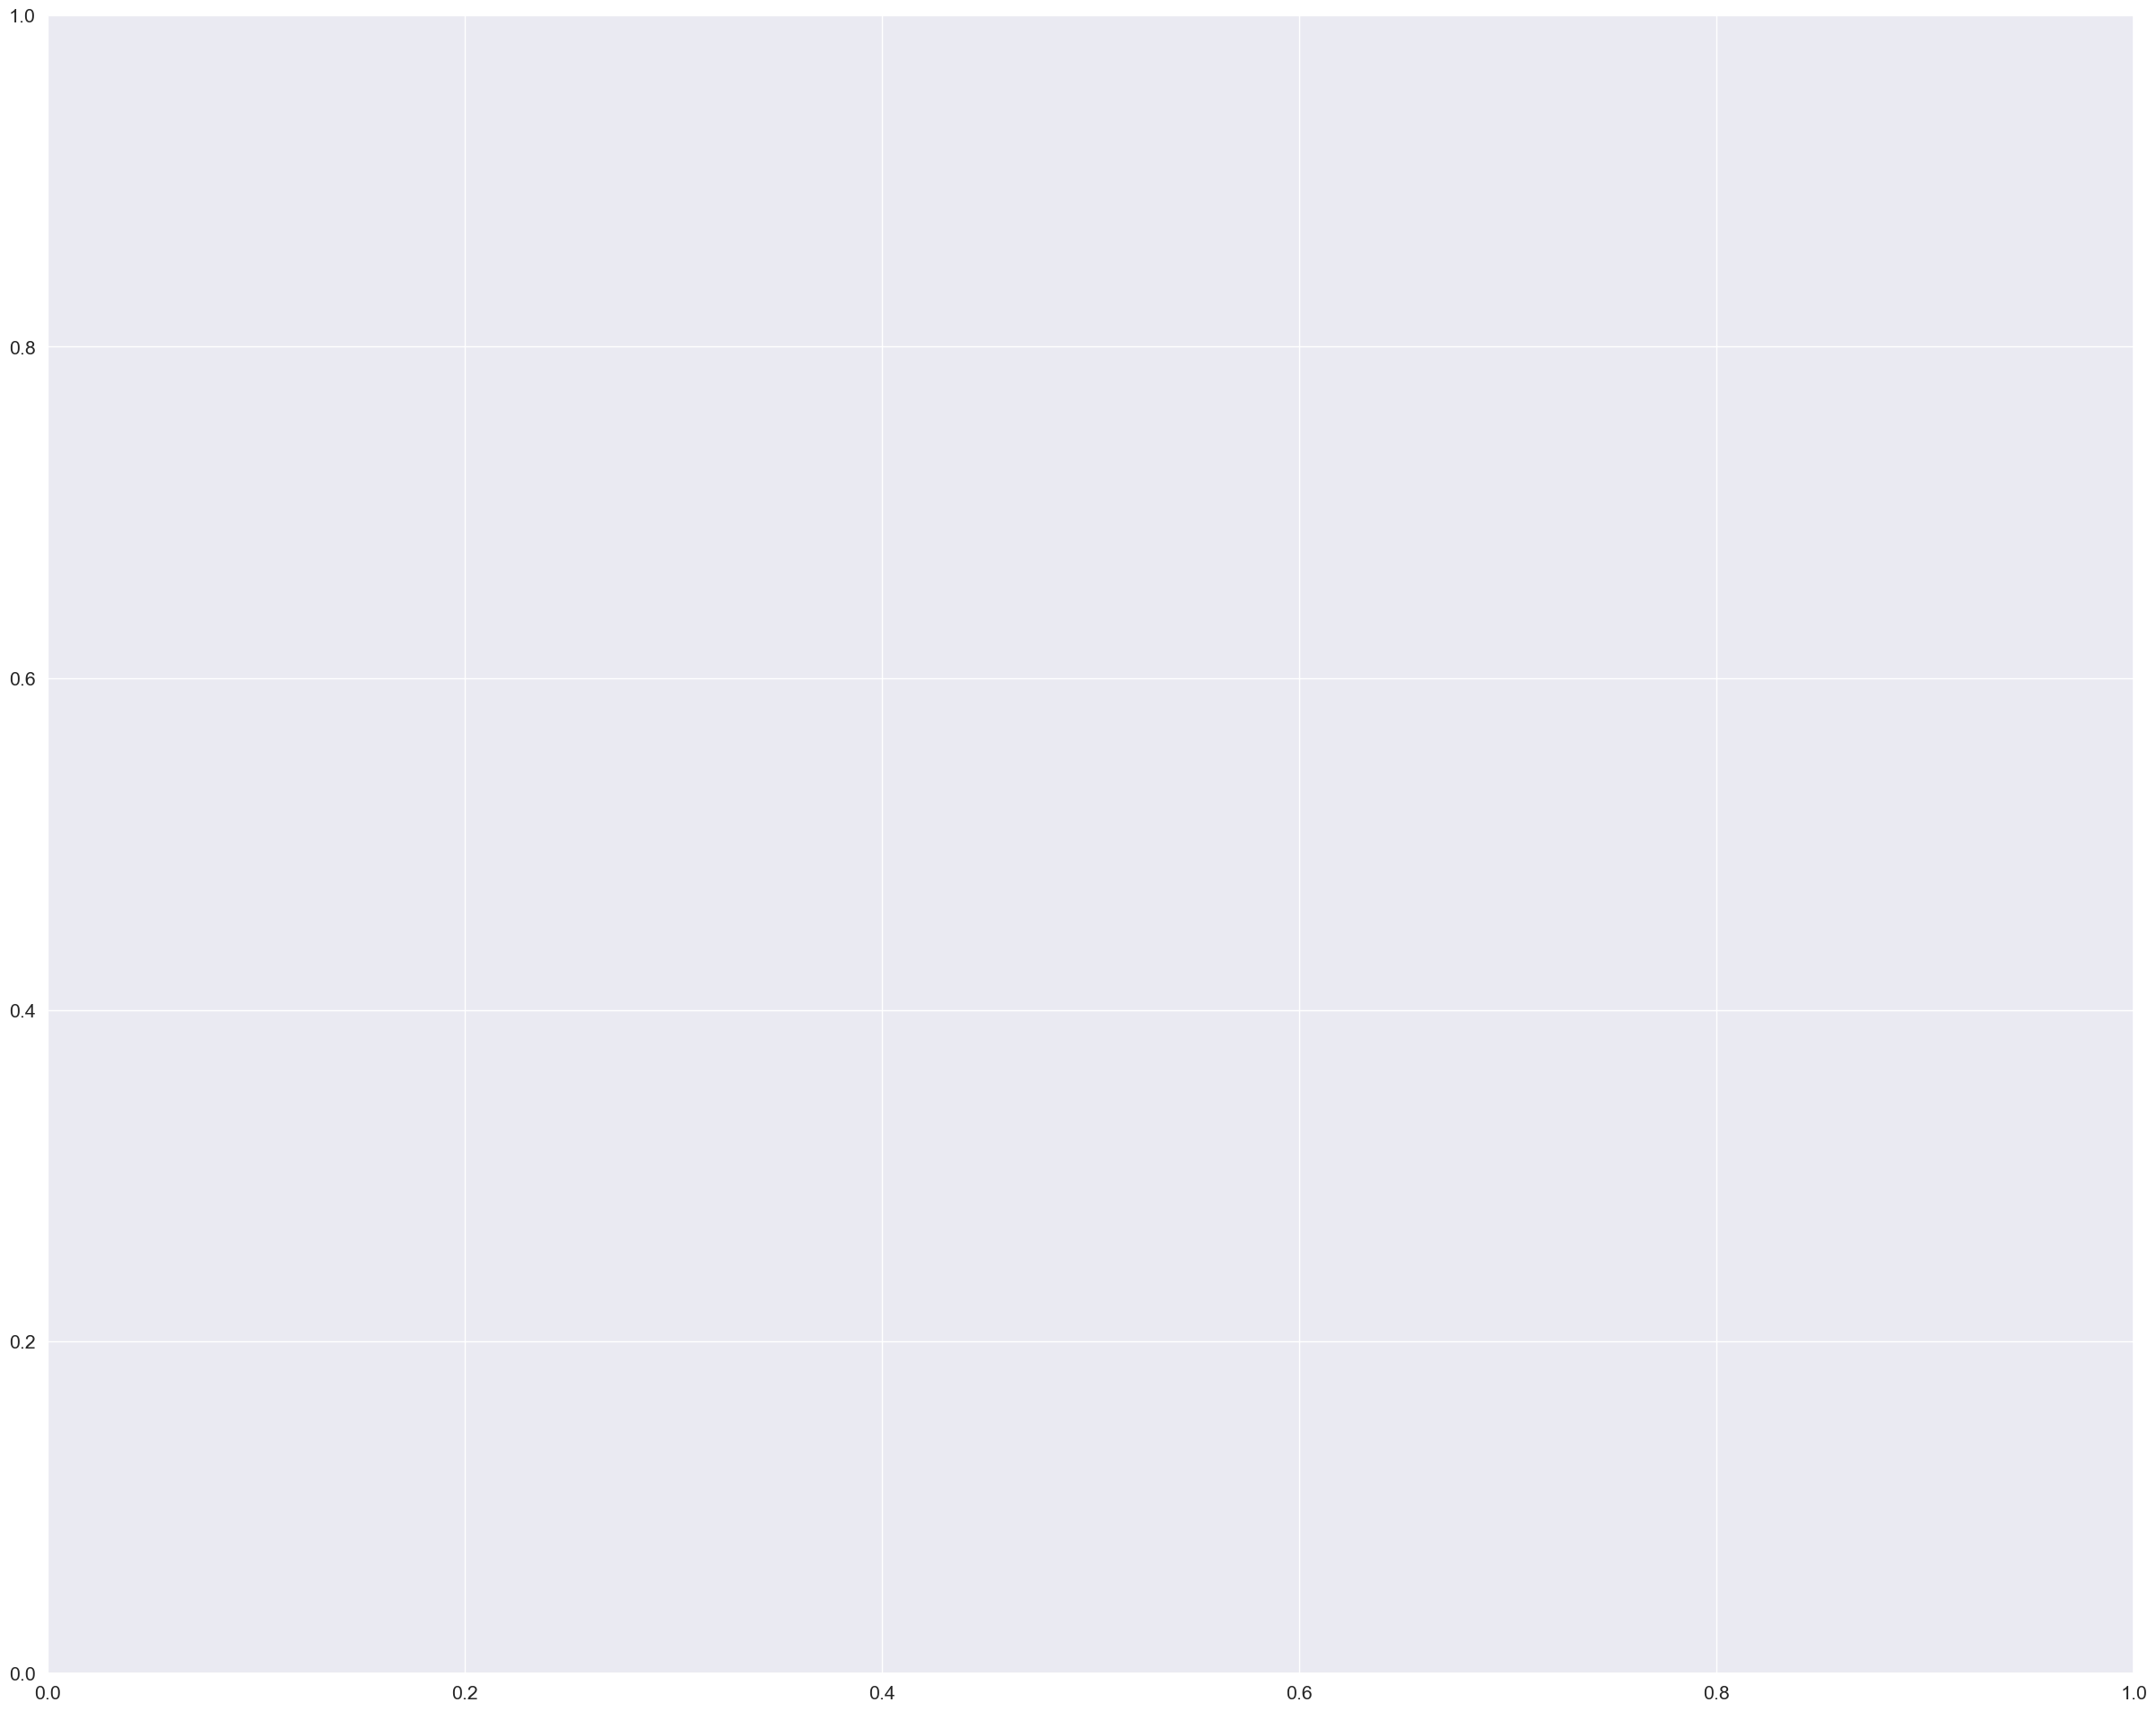

In [254]:
feature_importance(grid_search_LGBM)

## Pickle Model

In [175]:
import pickle
# Save to file in the current working directory
pkl_filename = "model_LGBM_Tuned.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_LGBM, file)

## GridSearch CV Regression Logistique

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from multiprocessing import cpu_count
# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('s', SMOTE(random_state=1)),
    ('r', RFE(estimator=LogisticRegression(random_state=1,max_iter=1000))),
    ('m', LogisticRegression(random_state=1))
])

# Define the parameter grid
param_grid = {
    'r__n_features_to_select': [40,50],  # RFE hyperparameter
    'r__step': [3,5], # RFE hyperparameter
    's__sampling_strategy': ['auto', 0.5],  # SMOTE : ratio entre l'échantillone dans la classe minoritaire et la classe majoritaire
    # 'm__penalty': ['l1', 'l2'], # Pénalité quand le modèle se trompe
    'm__C': [0.001,0.01, 0.1], # Plus ce paramètre est faible, plus la régularisation de la fontion de coût est élevée.
    'm__max_iter': [200, 300] # Nombre maximum d'itération pour que le solver converge
}

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)

# Effectuer une recherche par grille
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',  # Métrique d'évaluation
    cv=cv,
    verbose=0,
    n_jobs=cpu_count()
)
# Lancer la recherche sur les données (X, y)
lr_tuned_fitted = grid_search.fit(X_train, y_train)
y_prod_lr = lr_tuned_fitted.predict_proba(X_test)[:,1]
y_pred_lr = lr_tuned_fitted.predict(X_test)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score AUC :", grid_search.best_score_)

metrics_lr_tuned = get_model_metrics(lr_tuned_fitted, y_test, y_pred_lr, y_prod_lr)
log_model_mlflow(X_train, metrics_lr_tuned, lr_tuned_fitted, "LogisticRegression_Tuned", tag_model="Model Tuned")

Meilleurs paramètres : {'m__C': 0.1, 'm__max_iter': 200, 'r__n_features_to_select': 50, 'r__step': 5, 's__sampling_strategy': 0.5}
Meilleur score AUC : 0.7334427463764315
Le ROC AUC est de: 0.7562186496901852


Successfully registered model 'LogisticRegression_Tuned'.
2024/12/12 23:37:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_Tuned, version 1
Created version '1' of model 'LogisticRegression_Tuned'.
2024/12/12 23:37:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-slug-818 at: http://localhost:8080/#/experiments/495850407925590538/runs/a7c74af23bdf43619510951af13b9700.
2024/12/12 23:37:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/495850407925590538.


In [511]:
best_LR = grid_search.best_estimator_
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'m__C': 0.1, 'm__max_iter': 200, 'r__n_features_to_select': 50, 'r__step': 5, 's__sampling_strategy': 0.5}
Best Score: 0.7334427463764315


### Gradient Boosting Tuning

In [ ]:
param_grid = {
    'r__n_features_to_select': [40,50],  # RFE hyperparameter
    'r__step': [3,5],
    's__sampling_strategy': ['auto', 0.5],  # SMOTE hyperparameter# RFE hyperparameter
    # 'm__penalty': ['l1', 'l2'], # Pénalité quand le modèle se trompe
    'm__C': [0.001,0.01, 0.1],
    'm__max_iter': [ 200, 300]
}

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)

# Effectuer une recherche par grille
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',  # Métrique d'évaluation
    cv=cv,
    verbose=0,
    n_jobs=cpu_count()
)

In [ ]:
# Tuning Gradient Boosting Classifier

param_dist = {
    'n_estimators': [50, 100, 200], # Nombre d'arbres
    'max_depth': [10, 20, 30, 40, 50], # Profondeur / Nombre de noeuds dans l'arbre
    'min_samples_split': [5,10, 20, 30], # Taille d'échantillon minimum nécessaire pour splitté un noeud (noeur interieur)
    'min_samples_leaf':[10, 20, 30, 40, 50], # Taille d'échantillon minimum nécessaire sur un noeud (noeud exterieur)
    'max_features': ['sqrt', 'log2', None], # Nombre de feature à considérer pour checher le meilleur split
    'subsample': [0.8, 0.9, 1.0], # Ratio du Sous échantillon pour chaque itération avant de changer d'arbre
    'learning_rate': [0.1, 0.01, 0.001] # pas d'apprentissage à chaque itération, vitesse à laquelle le modèle essaye de converger
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# gbc = RandomizedSearchCV(GradientBoostingClassifier(),
#                             param_distributions=param_dist,
#                             n_iter=10,
#                             cv=cv,
#                             scoring='roc_auc',
#                             random_state=1,
#                             verbose=True,
#                             n_jobs=cpu_count())

gbc = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid = param_dist,
    # n_iter = 10,
    cv = cv,
    scoring = 'roc_auc',
    # random_state = 1,
    verbose = True,
    n_jobs = cpu_count()
)

# Handle class imbalance by setting sample weights
sample_weights = [1 if label == 0 else 9 for label in y_train]

gbc_fitted = gbc.fit(X_train, y_train, sample_weight=sample_weights)
y_prob_gbc = gbc_fitted.predict_proba(X_test)[:,1]
y_pred_gbc = gbc_fitted.predict(X_test)

metrics_gbc_tuned = get_model_metrics(gbc_fitted, y_test, y_pred_gbc, y_prob_gbc)
log_model_mlflow(X_train, metrics_gbc_tuned, gbc_fitted, "GradientBoostingClassifier_Tuned", tag_model="Model Tuned")

best_gbc = gbc.best_estimator_
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
best_gbc
print("Best parameter (CV score=%0.3f):" % gbc.best_score_)
print(gbc.best_params_)

### LGBM Classifier Tuning

In [ ]:
pipeline_lgbm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('s', SMOTE(random_state=1)),
    ('r', RFE(estimator=LGBMClassifier(objective="binary", metric="roc_auc", random_state=42, max_iter=10))),
    ('m', LGBMClassifier(random_state=42))
])

# Tuning LGBM Classifier
param_grid = {
    'r__n_features_to_select': [40,50],  # RFE hyperparameter
    'r__step': [3,5],
    's__sampling_strategy': ['auto', 0.5],  # SMOTE hyperparameter# RFE hyperparameter
    'm__num_leaves': [31, 62],
    "m__max_depth": [-1, 3, 5],
    "m__subsample": [0.8, 1.0],
    "m__colsample_bytree": [0.8, 1.0]
}

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)

# Effectuer une recherche par grille
grid_search_lgbm = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid,
    scoring='roc_auc',  # Métrique d'évaluation
    cv=cv,
    verbose=0,
    n_jobs=cpu_count()
)

# Fit the grid search object to the training data
grid_search_lgbm.fit(X_train, y_train)
# Print best parameters and score
print(f"Best parameters: {grid_search_lgbm.best_params_}")
print(f"Best score: {grid_search_lgbm.best_score_}")
# Use best estimator to make predictions on test set
y_pred = grid_search_lgbm.predict(X_test)


## Evaluation du Modèle

In [169]:
def roc_curve__confusion_matrix(model):
    from sklearn.metrics import roc_curve, auc
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train  = model.predict_proba(X_train)[:, 1]
    prediction=model.predict(X_test)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()

### Régression Logistique

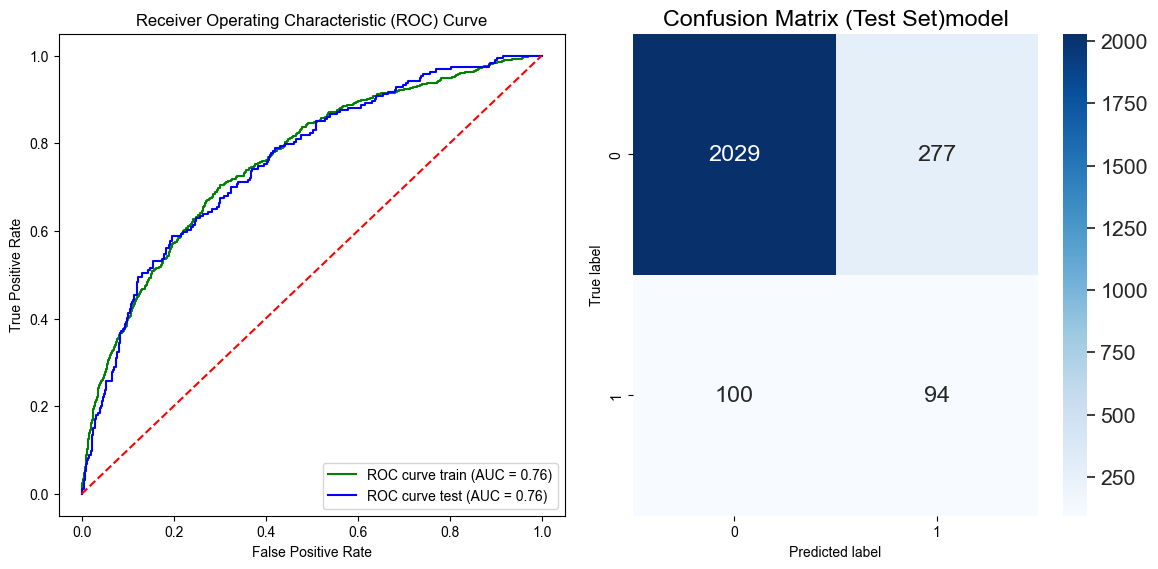

In [514]:
roc_curve__confusion_matrix(best_LR)


### Gradient Boosting

In [ ]:
roc_curve__confusion_matrix(best_gbc)


### Feature importance

In [173]:
def feature_importance(model):  
    
    # Extract features importance from model
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]
    feature_scores = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    important_features=feature_scores[:10]
    
    # Creating a seaborn bar plot for features importance
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=feature_scores)
    ax.set_title("Visualize feature scores of the features")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(feature_scores.index)
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()
    print(important_features)

In [185]:
feature_importance(best_LR)


NameError: name 'best_LR' is not defined

## Choix du modèle

In [ ]:
# Make a submission for Logistic Regression
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = best_LR.predict_proba(imputed_features_test)[:,1]
submit.to_csv('submission_LR.csv', index = False)